# A Maldição da Dimensionalidade
- Quanto mais features há no dado, o número de amostras deve crescer exponencialmente para manter os dados densos.
- Além disso, quanto maior a dimensão, mais chance do dado se encontrar em extremos

# Principais Abordagens para a Redução da Dimensionalidade
- Entretanto, felizmente grande parte da informação do dado se encontra em dimensões bem inferiores às do dado original.
- Portanto, pode-se projetar o dado em um plano de menor dimensão de forma linear ou capturando o seu manifold.
- Essas abordagens raramente melhoram o desempenho da máquina, mas acelera bastante o treinamento. Além disso, não necessariamente a nova solução será mais simples.

# PCA
- Acha o hiperplano cuja projeção dos dados preserva a máxima variância dos dados.
- SVD (Decomposição em valores singulares). X = U * Sigma * V_T
- V = vetores-coluna que têm todas as direções de maior variação do dado (ortogonais)
- Decompor X em n dimensões -> Xd = X * W_d => W_d = primeiras n colunas de V

In [1]:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

W2 = Vt.T[:, :2] # pega as duas primeiras componentes
X2D = X_centered.dot(W2)

## Scikit-Learn

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)
print(pca.components_.T) # vetores principais componentes
print(pca.explained_variance_ratio_) # proporção da variância em cada uma das PC's

[[-0.93636116  0.34027485]
 [-0.29854881 -0.90119108]
 [-0.18465208 -0.2684542 ]]
[0.84248607 0.14631839]


### Escolhendo o número correto de dimensões
- Número suficiente de componentes para ter pelo menos 95% da variância total.

In [3]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)
X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_) # soma cumulativa
d = np.argmax(cumsum >= 0.95) + 1

154


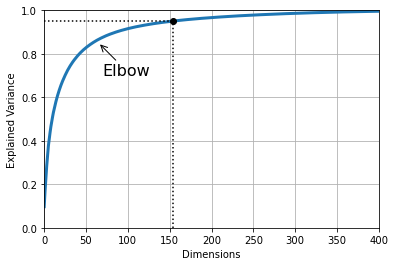

In [4]:
import matplotlib.pyplot as plt

print(d)
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

### PCA para compressão
- Naturalmente a transformação do PCA comprime os dados
- É possível voltar ao domínio original com alguma perda de informação
- Xrecovered = Xd * W_d_T (W_d^(-1)) 

In [5]:
from sklearn.metrics import mean_squared_error

pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

### PCA Incremental
- Quando o dataset é muito grande e não cabe na memória -> roda em mini-batches

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

In [ ]:
# NumPy memmap -> manipular um array do disco como se ele tivesse inteiramente na memória
# É possível pq o IncrementalPCA usa apenas uma parte do array
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))
batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

# Kernel PCA
- Assim como para a SVC, também é possível usar o truque do Kernel no PCA
- Assim, o dado é mapeado para uma dimensão maior antes de ser projetado

In [9]:
from sklearn.datasets import make_swiss_roll
from sklearn.decomposition import KernelPCA

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

rbf_pca = KernelPCA(n_components = 2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

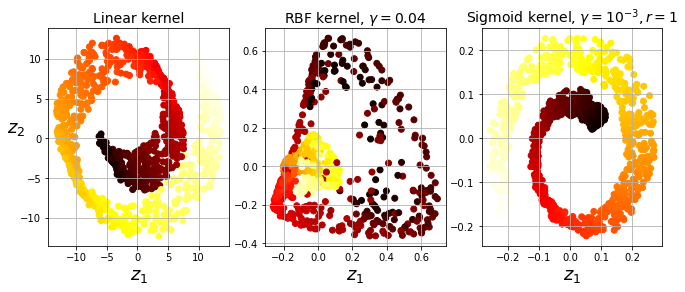

In [10]:
from sklearn.decomposition import KernelPCA

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Selecionado o Kernel e tunando os hiperparâmetros
- Não há uma métrica óbvia de performance

### Melhor performance do modelo
- Grid search -> selecionar o kernel e hiperparâmetros que levam a melhor performance do modelo (e.g. classificação)

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


### Menor erro de reconstrução
- Treinar um modelo de regressão supervisionado (X_reduced -> X_espaço_original)

In [12]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced=rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage) # pode-se fazer uma CV para minimizar esse erro

1.53216166141514e-26

# Locally Linear Embedding (LLE)
- Seleciona os k vizinhos mais próximos e, ao reduzir a dimensão, tenta preservar as relações de vizinhança.
- Como consequência, as distâncias locais são preservadas, mas não são preservadas em larga escala (vizinhos distantes)
- Complexidade (m -> número instâncias, n -> número de features):
<ol type="A" style='font-weight: bold;'>
    <li><p style='font-weight: normal;'>m &#215; log(m) &#215; n &#215; log(k): achar os k vizinhos</p></li>
    <li><p style='font-weight: normal;'>m &#215; n &#215; k<sup>3</sup>: otimizar os pesos</p></li>
    <li><p style='font-weight: normal;'>d &#215; m<sup>2</sup>: construir as representações na dimensão reduzida -> o termo m<sup>2</sup> faz com que o algoritmo não escale bem.</p></li>
</ol>

In [14]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

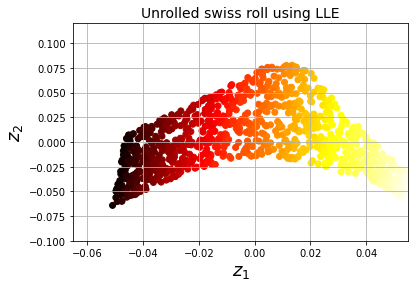

In [16]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()